In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk, string

# HW5
### 1 Word clouds

Let first look at some raw wordclouds. We build 2 of them:
- RawText column from the data
- ExtractedSubject and ExtractedBodyText columns concatenated

In [2]:
all_emails = pd.read_csv('hillary-clinton-emails/Emails.csv')
raw_corpus = '\n'.join(all_emails.RawText)
extracted_text = all_emails.ExtractedSubject.fillna('\n') + all_emails.ExtractedBodyText.fillna('\n')
extracted_emails = pd.DataFrame(extracted_text, columns=['Text'])
extracted_corpus = '\n'.join(extracted_emails.Text)

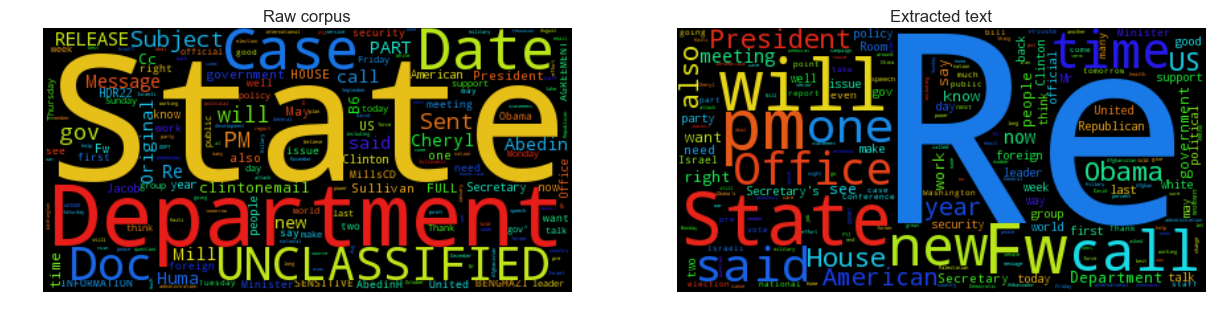

In [3]:
wordcloud = WordCloud().generate(raw_corpus)
wordcloud_extracted = WordCloud().generate(extracted_corpus)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.imshow(wordcloud)
ax1.set_title('Raw corpus')
ax1.axis('off')
ax2.imshow(wordcloud_extracted)
ax2.set_title('Extracted text')
ax2.axis('off')
plt.show()

As we can see, the RawText contains a lot of annotations (e.g. "UNCLASSIFIED U.S. Department of State Case No.").  
But the extracted text contains more short keywords (e.g. "Fw:", "Re:", etc.)

Now let create a pipeline:
- tokenize sentence and words
- remove stopwords (plus some more related to emails)
- stemming (using the Porter algorithm)

In [4]:
# Don't forget to run nltk.download() if not already done...
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def tokenize(text):
    tokenizer = RegexpTokenizer('\w+')
    return tokenizer.tokenize(text)

def remove_stopwords(words):
    # If using another tokenizer, add: ['n\'t','\'s','...','\'\'','``','--']
    stop_words = stopwords.words('english') + ['fvv','fw','fwd','re','am','pm']
    return [w.lower() for w in words if w.lower() not in stop_words]

def remove_punctuation(words):
    return [w for w in words if w not in string.punctuation]

def stemming(words):
    porter = nltk.PorterStemmer()
    return [porter.stem(w) for w in words]

def lemmantizing(words) :
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in words]

def run_pipeline(text,
                 return_as_str = False,
                 do_remove_stopwords=True, 
                 do_stemming=False,
                 do_lemmantizing=True,
                 do_remove_punctuation=True):
    words = tokenize(text)
    if do_remove_stopwords:
        words = remove_stopwords(words)
    if do_remove_punctuation:
        words = remove_punctuation(words)
    if do_stemming:
        words = stemming(words)
    if do_lemmantizing:
        words = lemmantizing(words)
    if return_as_str:
        return ' '.join(words)
    else:
        return words

In [5]:
try:
    processed_raw = np.load('processed_raw.npy').item()
    processed_extracted = np.load('processed_extracted.npy').item()
except:
    processed_raw = run_pipeline(raw_corpus, return_as_str=True)
    np.save('processed_raw', processed_raw)
    processed_extracted = run_pipeline(extracted_corpus, return_as_str=True)
    np.save('processed_extracted', processed_extracted)

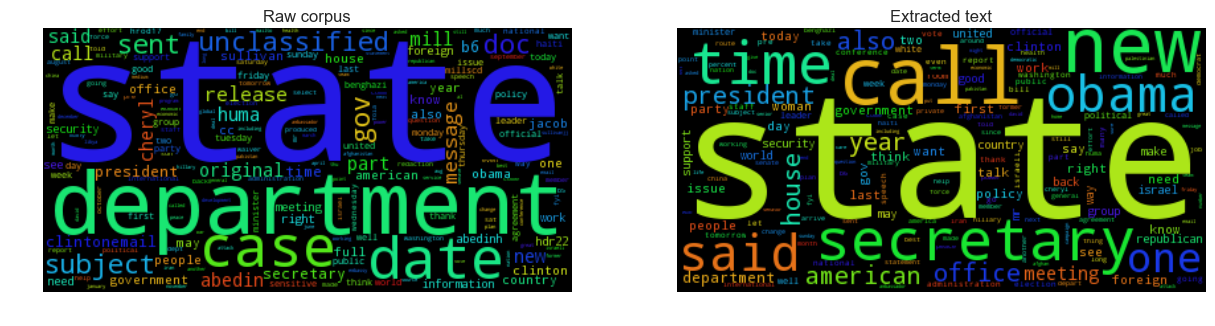

In [6]:
wordcloud = WordCloud().generate(processed_raw)
wordcloud_extracted = WordCloud().generate(processed_extracted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.imshow(wordcloud)
ax1.set_title('Raw corpus')
ax1.axis('off')
ax2.imshow(wordcloud_extracted)
ax2.set_title('Extracted text')
ax2.axis('off')
plt.show()

The two wordclouds are very close together. We also remark that the difference between Raw and Extracted is way smaller in the second approach.  
Pros and cons:  

- The first approach is much faster and straightforward but it could lack some fine grained tuning regarding language processing.  
- The second one is way slower as we run through many pre-processing steps. But its main advantage is the ability to tune some parameters (stopwords, stemming, lemmantizing, etc.).

Here, we prefer not to do stemming. Indeed, this might change considerably the country analysis as well as the sentiment analysis.

### Part 2

Finding countries in the whole corpus:

__Note:__ We only retrieve countries by their name in the Extracted dataset.  
_When trying with abbreviations we get a lot of false results because of short keywords and US appears almost everywhere._

In [7]:
from pycountry import countries

def get_country(str):
    c = None
    try:
        if len(str) > 3: # Country names are >3 letters
            c = countries.get(name=str.title()).name
    except:
        pass
    return c

def retrieve_countries(emails):
    mentioned = {}
    
    def add(country, i):
        if country in mentioned:
            mentioned[country].append(i)
        else:
            mentioned[country] = [i]
    
    for i, email in emails.iteritems():
        tokens = run_pipeline(email)
        for token in tokens:
            country = get_country(token)
            if country:
                add(country, i)
    return mentioned

try:
    mentioned2 = np.load('mentioned2.npy').item()
except:
    mentioned2 = retrieve_countries(extracted_emails.Text)
    np.save('mentioned2.npy', mentioned2)

Now we compute the polarities using NLTK vader package:

In [8]:
try:
    polarities2 = np.load('polarities2.npy')
except:
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    sid = SentimentIntensityAnalyzer()
    polarities2 = [sid.polarity_scores(email) for email in extracted_emails.Text]
    np.save('polarities2.npy', polarities2)

In [9]:
result = []
for country, emails in mentioned2.items():
    for email in set(emails):
        polarity = polarities2[email]['compound']
        result.append([country, polarity])
result = pd.DataFrame(result, columns=['Country','Polarity'])
sorted = result.groupby('Country').mean().sort_values(by='Polarity')
colors = ['b' if pol > 0 else 'r' for pol in sorted.Polarity]

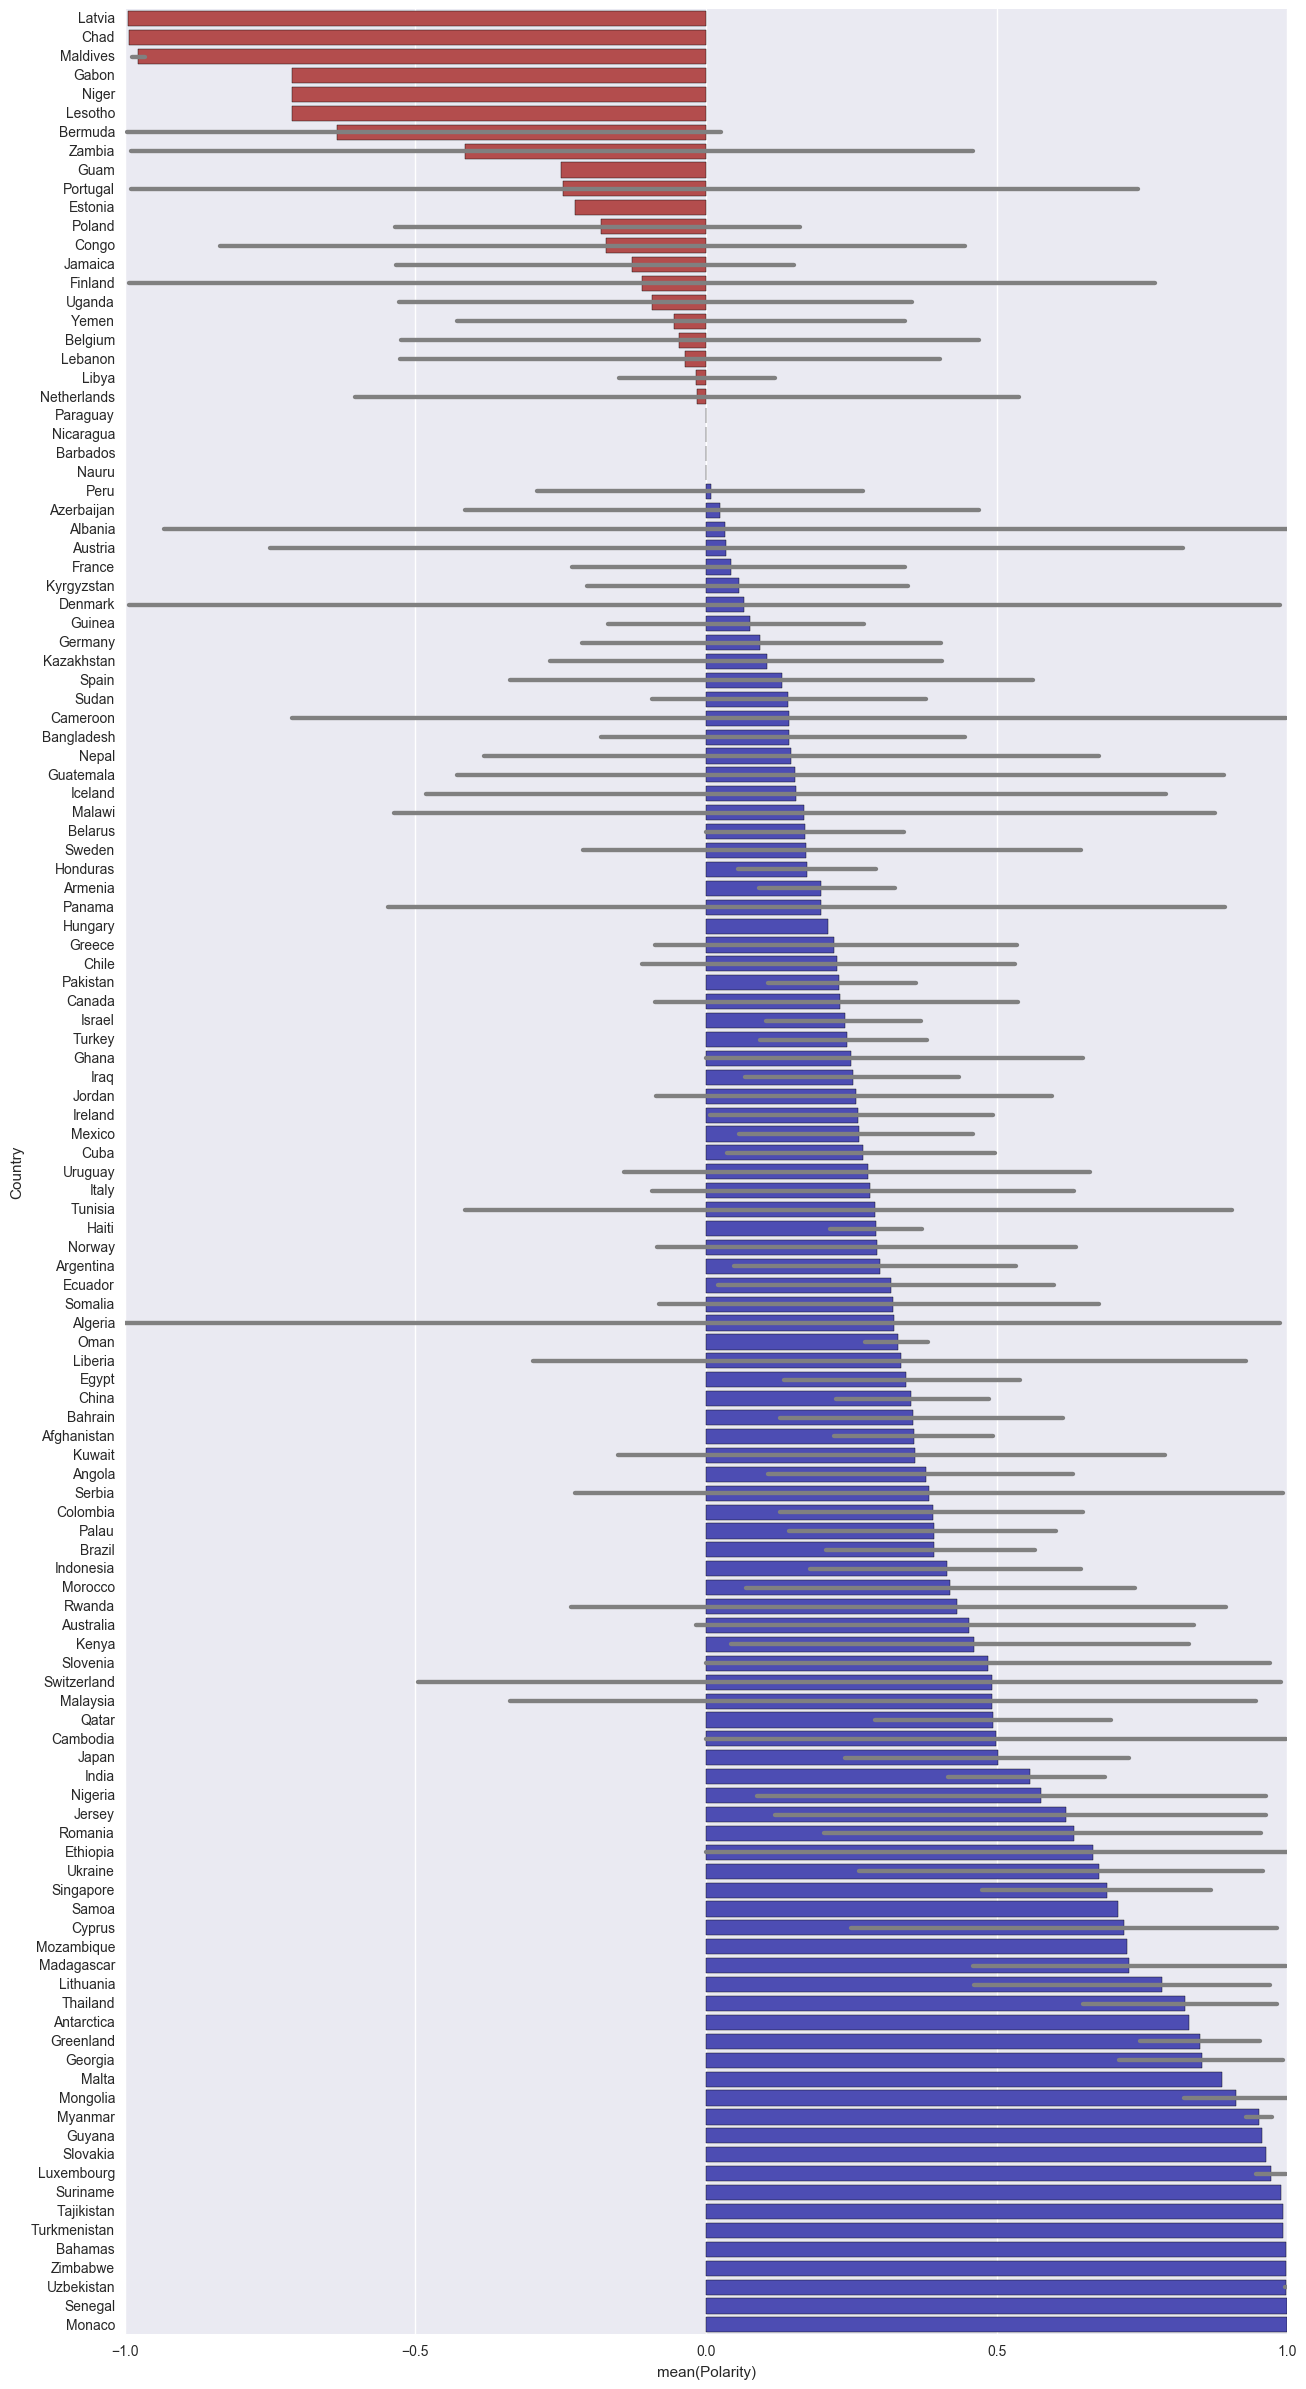

In [10]:
plt.subplots(figsize=(15,30))
sns.barplot(x='Polarity', 
            y='Country', 
            data=result, 
            order=sorted.index, 
            palette=colors, 
            saturation=.4, 
            errcolor='gray')
plt.show()

The plot shows the different average of sentiments per country. The gray part represents the standard deviation between each emails. A country with a big country would have a tendency to be _good_ or _bad_, other will tend to be only _good_ or _bad_.

### Part 3

Exploring the topics:

In [11]:
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


Let first construct a corpus. A corpus, in this case, is a ensemble of tuple $(i,n_i)$ where $i$ is the $i$th word and $n_i$ is the number of occurence of this word.

In [12]:
tokens = [run_pipeline(text) for text in extracted_emails.Text]
dictionary = Dictionary(tokens)
corpus = [dictionary.doc2bow(t) for t in tokens]

In [13]:
N_TOPICS = 15
lda = LdaModel(corpus, num_topics=N_TOPICS, id2word=dictionary)

In [14]:
for no in range(lda.num_topics):
    words = ' '.join([w for w, _ in lda.show_topic(no, topn=20)])
    print(no+1,':',words)

1 : secretary office 30 00 w 10 8 meeting state room 15 9 department 2 route en arrive 11 12 depart
2 : u would israel state one also government year new right american afghanistan people peace like security said effort obama support
3 : call office secretary w percent please 2 william wilson alexander 202 talk 647 party note 3 fm good min chicago
4 : print iran b woman 2010 reminder state said clinton strobe hiker un 1 one report iranian h hillary talbott 2009
5 : 2010 state gov h cheryl b6 mill com clintonemail fyi j sullivan hrod17 jacob millscd part huma friday sullivanjj sunday
6 : ap israel u reuters state american say peace palestinian anti israeli settlement ashton president right government muslim jewish people panel
7 : said republican party state boehner democrat would bill vote house senate political right u obama american one last time year
8 : party state u labour said branch house gaza new one obama beck american book white david government year political president
9 : o

By iterating over different `N_TOPICS` values, it appears that 15 seems to be a good value for this. 

### Part 4 BONUS:

In [15]:
receivers = pd.read_csv('hillary-clinton-emails/EmailReceivers.csv', header=0, index_col=0)
senders = all_emails[['Id','SenderPersonId']]
senders = senders[pd.notnull(senders.SenderPersonId)]
percent = 100*len(senders)/len(all_emails)
print('%.2f' % percent, '% of emails have a valid sender.')

98.02 % of emails have a valid sender.


In [16]:
import community
import networkx as nx

G = nx.Graph()
for _, emailId, i in senders.itertuples():
    for _, emailId_2, j in receivers[receivers.EmailId == emailId].itertuples():
        assert emailId == emailId_2 # Check for coherence
        G.add_edge(int(i), int(j))
partitions = community.best_partition(G)

In [17]:
communities = {}
for k,v in partitions.items():
    emails = ' '.join(extracted_emails[all_emails.SenderPersonId == k].Text)
    if not v in communities:
        communities[v] = [emails]
    else:
        communities[v].append(emails)

In [18]:
from collections import Counter

for k,v in communities.items():
    text = ' '.join(v)
    tokens = run_pipeline(text)
    count = Counter(tokens)
    most = ' '.join(pd.DataFrame(count.most_common(20))[0]) if count else ''
    print(k+1,':',most)

1 : 
2 : 
3 : call state h w com gov hrod17 clintonemail u get time see know would 2009 talk thx 2010 pls print
4 : state u 2015 call would agreement said government united 1 benghazi department president work people case one house 4 subject
5 : state u woman said new clinton would one also time issue 2010 policy foreign year work think president government obama
6 : 
7 : woman said mr richards year say one new place people life fisa first day time city vote jamal candidate state
8 : un settlement people haitian e work government g plan latrine could would though need one prince port committee au least
9 : u call state talk ap want huma reuters gov said abedin mr abedinh 2009 would also h meeting today time
10 : state obama would u president one american 1 time said new party year republican 2009 house right 2010 2 government
11 : state 2015 u information department house subject would 13 date agreement sensitive secretary 05 right benghazi f case doc select
12 : 
13 : 
14 : office sec

We got 18 communities here and the subjects are not the same as the topic analysis.  
This was expected as the LDA model tries to figure out topics but here we only count word occurencies.
The most interesting fact is that we can clearly identify discussion topics here but it looks more unclear in the LDA model.